# Using submodels in PyBaMM
In this notebook we show how to modify existing models by swapping out submodels, and how to build your own model from scratch using existing submodels. To see all of the models and submodels available in PyBaMM, please take a look at the documentation [here](https://pybamm.readthedocs.io/en/latest/source/models/index.html).

## Changing a submodel in an exisiting battery model
PyBaMM is designed to be a flexible modelling package that allows users to easily compare different models and numerical techniques within a common framework. Battery models within PyBaMM are built up using a number of submodels that describe different physics included within the model, such as mass conservation in the electrolyte or charge conservation in the solid. For ease of use, a number of popular battery models are pre-configured in PyBaMM. As an example, we look at the Single Particle Model (for more information see [here](./models/SPM.ipynb)). 

First we import pybamm

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm

You should consider upgrading via the '/Users/vsulzer/Documents/Energy_storage/PyBaMM/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Then we load the SPM

In [2]:
model = pybamm.lithium_ion.SPM()

We can look at the submodels that make up the SPM by accessing `model.submodels`, which is a dictionary of the submodel's name (i.e. the physics it represents) and the submodel that is selected

In [3]:
for name, submodel in model.submodels.items():
    print(name, submodel)

external circuit <pybamm.models.submodels.external_circuit.current_control_external_circuit.CurrentControl object at 0x14c02e520>
porosity <pybamm.models.submodels.porosity.constant_porosity.Constant object at 0x14c0b6f70>
negative active material <pybamm.models.submodels.active_material.constant_active_material.Constant object at 0x14c0a4970>
positive active material <pybamm.models.submodels.active_material.constant_active_material.Constant object at 0x14c09bd90>
electrolyte tortuosity <pybamm.models.submodels.tortuosity.bruggeman_tortuosity.Bruggeman object at 0x14c0b6eb0>
electrode tortuosity <pybamm.models.submodels.tortuosity.bruggeman_tortuosity.Bruggeman object at 0x14c0b1d00>
through-cell convection <pybamm.models.submodels.convection.through_cell.no_convection.NoConvection object at 0x14c0ca250>
transverse convection <pybamm.models.submodels.convection.transverse.no_convection.NoConvection object at 0x14c0ca310>
negative interface <pybamm.models.submodels.interface.inverse_kin

When you load a model in PyBaMM it builds by default. Building the model sets all of the model variables and sets up any variables which are coupled between different submodels: this is the process which couples the submodels together and allows one submodel to access variables from another. If you would like to swap out a submodel in an existing battery model you need to load it without building it by passing the keyword `build=False`

In [4]:
model = pybamm.lithium_ion.SPM(build=False)

This collects all of the submodels which make up the SPM, but doesn't build the model. Now you are free to swap out one submodel for another. For instance, you may want to assume that diffusion within the negative particles is infinitely fast, so that the PDE describing diffusion is replaced with an ODE for the uniform particle concentration. To change a submodel you simply update the dictionary entry, in this case to the `XAveragedPolynomialProfile` submodel

In [5]:
model.submodels["negative particle"] = pybamm.particle.no_distribution.XAveragedPolynomialProfile(model.param, "Negative","uniform profile")

where we pass in the model parameters, the electrode (negative or positive) the submodel corresponds to, and the name of the polynomial we want to use. In the example we assume uniform concentration within the particle, corresponding to a zero-order polynomial.

Now if we look at the submodels again we see that the model for the negative particle has been changed

In [6]:
for name, submodel in model.submodels.items():
    print(name, submodel)

external circuit <pybamm.models.submodels.external_circuit.current_control_external_circuit.CurrentControl object at 0x14c40c670>
porosity <pybamm.models.submodels.porosity.constant_porosity.Constant object at 0x14c49c370>
negative active material <pybamm.models.submodels.active_material.constant_active_material.Constant object at 0x14c49c790>
positive active material <pybamm.models.submodels.active_material.constant_active_material.Constant object at 0x14c49c850>
electrolyte tortuosity <pybamm.models.submodels.tortuosity.bruggeman_tortuosity.Bruggeman object at 0x14c49c0a0>
electrode tortuosity <pybamm.models.submodels.tortuosity.bruggeman_tortuosity.Bruggeman object at 0x14c49c9a0>
through-cell convection <pybamm.models.submodels.convection.through_cell.no_convection.NoConvection object at 0x14c49ca60>
transverse convection <pybamm.models.submodels.convection.transverse.no_convection.NoConvection object at 0x14c49cb20>
negative interface <pybamm.models.submodels.interface.inverse_kin

Building the model also sets up the equations, boundary and initial conditions for the model. For example, if we look at `model.rhs` before building we see that it is empty 

In [7]:
model.rhs

{}

If we try to use this empty model, PyBaMM will give an error. So, before proceeding we must build the model

In [8]:
model.build_model()

Now if we look at `model.rhs` we see that it contains an entry relating to the concentration in each particle, as expected for the SPM

In [9]:
model.rhs

{Variable(0x52e60f6b8b1ed1db, Discharge capacity [A.h], children=[], domain=[], auxiliary_domains={}): Division(0x418cff78eab51419, /, children=['Current function [A] * 96485.33212 * Maximum concentration in negative electrode [mol.m-3] * (Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m]) / absolute(Typical current [A] / (Number of electrodes connected in parallel to make a cell * Electrode width [m] * Electrode height [m]))', '3600.0'], domain=[], auxiliary_domains={}),
 Variable(0x2cfd9d4ec9544484, R-X-averaged negative particle concentration, children=[], domain=['current collector'], auxiliary_domains={}): MatrixMultiplication(-0x358ad09406cf7a4d, @, children=['mass(R-X-averaged negative particle concentration)', 'broadcast(-3.0 * (Current function [A] / Typical current [A]) * sign(Typical current [A]) / (Negative electrode thickness [m] / (Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m])) / 

Now the model can be used in a simulation and solved in the usual way, and we still have access to model defaults such as the default geometry and default spatial methods which are used in the simulation

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

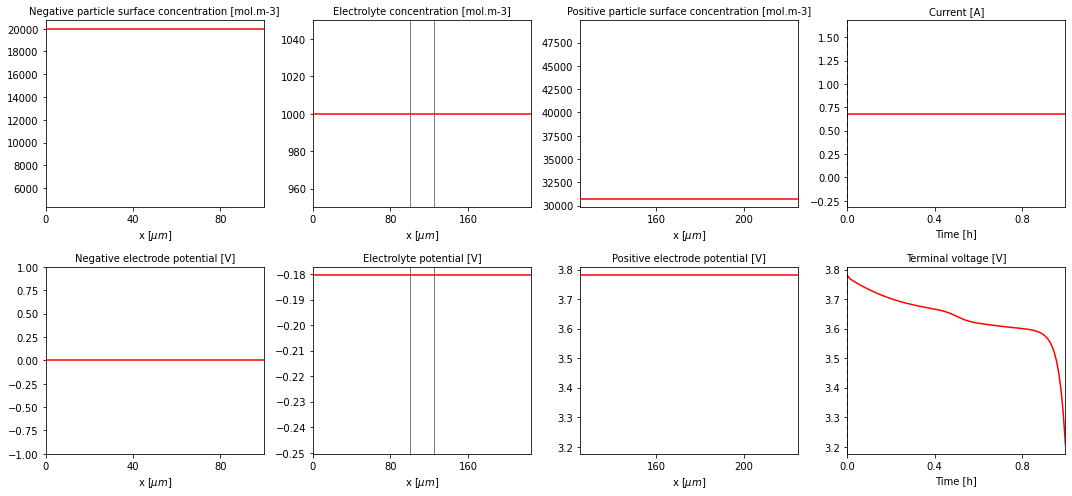

In [10]:
simulation = pybamm.Simulation(model)
simulation.solve([0, 3600])
simulation.plot()

## Building a custom model from submodels
Instead of editing a pre-existing model, you may wish to build your own model from scratch by combining existing submodels of you choice. In this section, we build a Single Particle Model in which the diffusion is assumed infinitely fast in both particles. 

To begin, we load a base lithium-ion model. This sets up the basic model structure behind the scenes, and also sets the default parameters to be those corresponding to a lithium-ion battery. Note that the base model does not select any default submodels, so there is no need to pass `build=False`.

In [11]:
model = pybamm.lithium_ion.BaseModel()

Submodels can be added to the `model.submodels` dictionary in the same way that we changed the submodels earlier. 

We use the simplest model for the external circuit, which is the "current control" submodel

In [12]:
model.submodels["external circuit"] = pybamm.external_circuit.CurrentControl(model.param)

We want to build a 1D model, so select the `Uniform` current collector model (if the current collectors are behaving uniformly, then a 1D model is appropriate). We also want the model to be isothermal, so select the thermal model accordingly. Further, we assume that the porosity and active material are constant in space and time.

In [13]:
model.submodels["current collector"] = pybamm.current_collector.Uniform(model.param)
model.submodels["thermal"] = pybamm.thermal.isothermal.Isothermal(model.param)
model.submodels["porosity"] = pybamm.porosity.Constant(model.param, model.options)
model.submodels["negative active material"] = pybamm.active_material.Constant(
    model.param, "Negative", model.options
)
model.submodels["positive active material"] = pybamm.active_material.Constant(
    model.param, "Positive", model.options
)

We assume that the current density varies linearly in the electrodes. This corresponds the the leading-order terms in Ohm's law in the limit in which the SPM is derived in [[3]](#References)

In [14]:
model.submodels["negative electrode potentials"] = pybamm.electrode.ohm.LeadingOrder(
    model.param, "Negative"
)
model.submodels["positive electrode potentials"] = pybamm.electrode.ohm.LeadingOrder(
    model.param, "Positive"
)

We assume uniform concentration in both the negative and positive particles 

In [15]:
model.submodels["negative particle"] = pybamm.particle.no_distribution.PolynomialProfile(
    model.param, "Negative", "uniform profile"
)
model.submodels["positive particle"] = pybamm.particle.no_distribution.PolynomialProfile(
    model.param, "Positive", "uniform profile"
)

In the Single Particle Model, the overpotential can be obtianed by inverting the Butler-Volmer relation, so we choose the `InverseButlerVolmer` submodel for the interface, with the "main" lithium-ion reaction (and default lithium ion options). Because of how the current is implemented, we also need to separately specify the `CurrentForInverseButlerVolmer` submodel

In [16]:
model.submodels[
    "negative interface"
] = pybamm.interface.InverseButlerVolmer(
    model.param, "Negative", "lithium-ion main", options=model.options
)
model.submodels[
    "positive interface"
] = pybamm.interface.InverseButlerVolmer(
    model.param, "Positive", "lithium-ion main", options=model.options
)
model.submodels[
    "negative interface current"
] = pybamm.interface.CurrentForInverseButlerVolmer(
    model.param, "Negative", "lithium-ion main"
)
model.submodels[
    "positive interface current"
] = pybamm.interface.CurrentForInverseButlerVolmer(
    model.param, "Positive", "lithium-ion main"
)

We don't want any SEI formation or lithium plating in this model

In [17]:
model.submodels["sei"] = pybamm.sei.NoSEI(model.param)
model.submodels["lithium plating"] = pybamm.lithium_plating.NoPlating(model.param)

Finally, for the electrolyte we assume that diffusion is infinitely fast so that the concentration is uniform, and also use the leading-order model for charge conservation, which leads to a linear variation in ionic current in the electrodes

In [18]:
model.submodels["electrolyte diffusion"] = pybamm.electrolyte_diffusion.ConstantConcentration(
    model.param
)
model.submodels["electrolyte conductivity"] = pybamm.electrolyte_conductivity.LeadingOrder(
    model.param
)

Now that we have set all of the submodels we can build the model

In [19]:
model.build_model()

We can then use the model in a simulation in the usual way

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

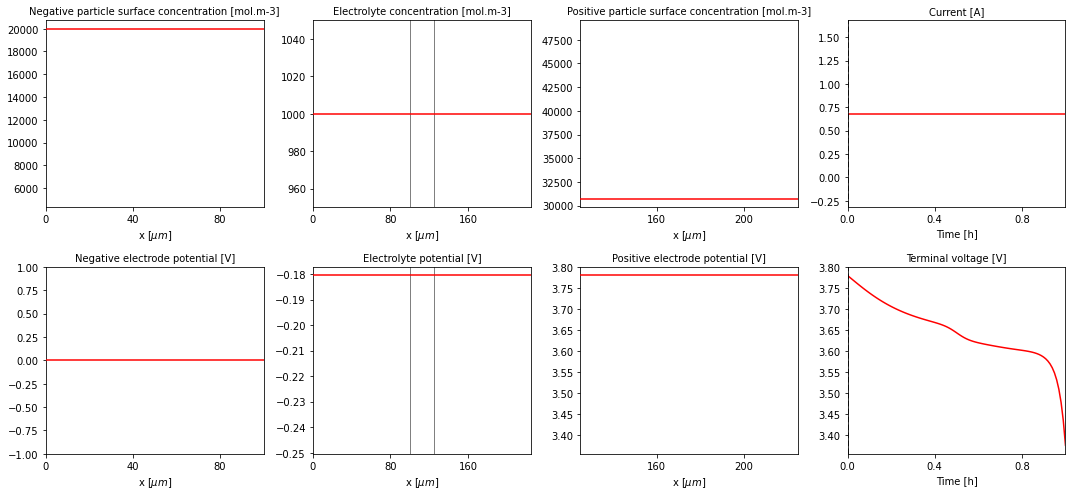

In [20]:
simulation = pybamm.Simulation(model)
simulation.solve([0, 3600])
simulation.plot()

## References

The relevant papers for this notebook are:

In [21]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with electrolyte. Journal of The Electrochemical Society, 166(15):A3693–A3706, 2019. doi:10.1149/2.0341915jes.
[4] Venkat R. Subramanian, Vinten D. Diwakar, and Deepak Tapriyal. Efficient macro-micro scale coupled modeling of batteries. Journal of The Electrochemical Society, 152(10):A2002, 2005. doi:10.1149/1.2032427.
